# 09 - Viscoelastic wave equation implementation on a staggered grid

This is a first attempt at implementing the viscoelastic wave equation as described in [1]. See also the FDELMODC implementation by Jan Thorbecke [2]. 

In the following example, a three dimensional toy problem will be introduced consisting of a single Ricker source located at (100, 50, 35) in a 200 m $\times$ 100 m $\times$ 100 *m* domain.

In [1]:
# Required imports:
import numpy as np
import sympy as sp

from devito import *
from examples.seismic.source import RickerSource, TimeAxis
from examples.seismic import ModelViscoelastic, plot_image

The model domain is now constructed. It consists of an upper layer of water, 50 m in depth, and a lower rock layer separated by a 4 m thick sediment layer.

In [2]:
# Domain size:
extent = (200., 100., 100.) # 200 x 100 x 100 m domain
h = 1.0 # Desired grid spacing
shape = (int(extent[0]/h+1), int(extent[1]/h+1), int(extent[2]/h+1))

# Model physical parameters:
vp = np.zeros(shape)
qp = np.zeros(shape)
vs = np.zeros(shape)
qs = np.zeros(shape)
rho = np.zeros(shape)

# Set up three horizontally separated layers:
vp[:,:,:int(0.5*shape[2])+1] = 1.52
qp[:,:,:int(0.5*shape[2])+1] = 10000.
vs[:,:,:int(0.5*shape[2])+1] = 0.
qs[:,:,:int(0.5*shape[2])+1] = 0.
rho[:,:,:int(0.5*shape[2])+1] = 1.05

vp[:,:,int(0.5*shape[2])+1:int(0.5*shape[2])+1+int(4/h)] = 1.6
qp[:,:,int(0.5*shape[2])+1:int(0.5*shape[2])+1+int(4/h)] = 40.
vs[:,:,int(0.5*shape[2])+1:int(0.5*shape[2])+1+int(4/h)] = 0.4
qs[:,:,int(0.5*shape[2])+1:int(0.5*shape[2])+1+int(4/h)] = 30.
rho[:,:,int(0.5*shape[2])+1:int(0.5*shape[2])+1+int(4/h)] = 1.3

vp[:,:,int(0.5*shape[2])+1+int(4/h):] = 2.2
qp[:,:,int(0.5*shape[2])+1+int(4/h):] = 100.
vs[:,:,int(0.5*shape[2])+1+int(4/h):] = 1.2
qs[:,:,int(0.5*shape[2])+1+int(4/h):] = 70.
rho[:,:,int(0.5*shape[2])+1+int(4/h):] = 2.

Now create a Devito vsicoelastic model generating an appropriate computational grid along with absorbing boundary layers:

In [3]:
# Create model
origin = (0, 0, 0)
spacing = (h, h, h)
so = 4 # FD space order (Note that the time order is by default 1).
nbl = 20 # Number of absorbing boundary layers cells
model = ModelViscoelastic(space_order=so, vp=vp, qp=qp, vs=vs, qs=qs,
                          b=1/rho, origin=origin, shape=shape, spacing=spacing,
                          nbl=nbl)

Operator `initdamp` ran in 0.01 s


In [4]:
# As pointed out in Thorbecke's implementation and documentation, the viscoelastic wave euqation is
# not always stable with the standard elastic CFL condition. We enforce a smaller critical dt here
# to ensure the stability.
model.dt_scale = .9

The source frequency is now set along with the required model parameters:

In [5]:
# Source freq. in MHz (note that the source is defined below):
f0 = 0.12

# Thorbecke's parameter notation
l = model.lam
mu = model.mu
ro = model.b

k = 1.0/(l + 2*mu)
pi = l + 2*mu

t_s = (sp.sqrt(1.+1./model.qp**2)-1./model.qp)/f0
t_ep = 1./(f0**2*t_s)
t_es = (1.+f0*model.qs*t_s)/(f0*model.qs-f0**2*t_s)

In [6]:
# Time step in ms and time range:
t0, tn = 0., 30.
dt = model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)

Generate Devito time functions for the velocity, stress and memory variables appearing in the viscoelastic model equations. By default, the initial data of each field will be set to zero.

In [7]:
# PDE fn's:
x, y, z = model.grid.dimensions
damp = model.damp

# Staggered grid setup:

# Velocity:
v = VectorTimeFunction(name="v", grid=model.grid, time_order=1, space_order=so)

# Stress:
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=1)

# Memory variable:
r = TensorTimeFunction(name='r', grid=model.grid, space_order=so, time_order=1)

s = model.grid.stepping_dim.spacing # Symbolic representation of the model grid spacing

And now the source and PDE's are constructed:

In [8]:
# Source
src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range)
src.coordinates.data[:] = np.array([100., 50., 35.])

# The source injection term
src_xx = src.inject(field=tau[0, 0].forward, expr=src*s)
src_yy = src.inject(field=tau[1, 1].forward, expr=src*s)
src_zz = src.inject(field=tau[2, 2].forward, expr=src*s)

# Particle velocity
pde_v = v.dt - ro * div(tau)
u_v = Eq(v.forward, model.damp * solve(pde_v, v.forward))
# Strain
e = grad(v.forward) + grad(v.forward).transpose(inner=False)

# Stress equations
pde_tau = tau.dt - r.forward - l * t_ep / t_s * diag(div(v.forward)) -  mu * t_es / t_s * e
u_t = Eq(tau.forward, model.damp * solve(pde_tau, tau.forward))

# Memory variable equations:
pde_r = r.dt + 1 / t_s * (r + l * (t_ep/t_s-1) * diag(div(v.forward)) + mu * (t_es/t_s-1) * e)
u_r = Eq(r.forward, damp * solve(pde_r, r.forward))

We now create and then run the operator:

In [9]:
# Create the operator:
op = Operator([u_v, u_r, u_t] + src_xx + src_yy + src_zz,
               subs=model.spacing_map)

In [10]:
#NBVAL_IGNORE_OUTPUT

# Execute the operator:
op(dt=dt)

Operator `Kernel` ran in 6.41 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.01217, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.012558, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=6.369124000000002, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.0019069999999999988, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Before plotting some results, let us first look at the shape of the data stored in one of our time functions:

In [11]:
v[0].data.shape

(2, 241, 141, 141)

Since our functions are first order in time, the time dimension is of length 2. The spatial extent of the data includes the absorbing boundary layers in each dimension (i.e. each spatial dimension is padded by 20 grid points to the left and to the right).

The total number of instances in time considered is obtained from:

In [12]:
time_range.num

158

Hence 223 time steps were executed. Thus the final time step will be stored in index given by:

In [13]:
np.mod(time_range.num,2)

np.int64(0)

Now, let us plot some 2D slices of the fields `vx` and `szz` at the final time step:

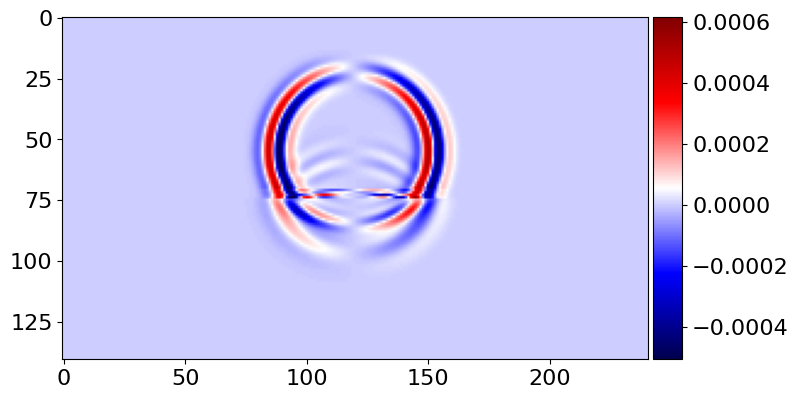

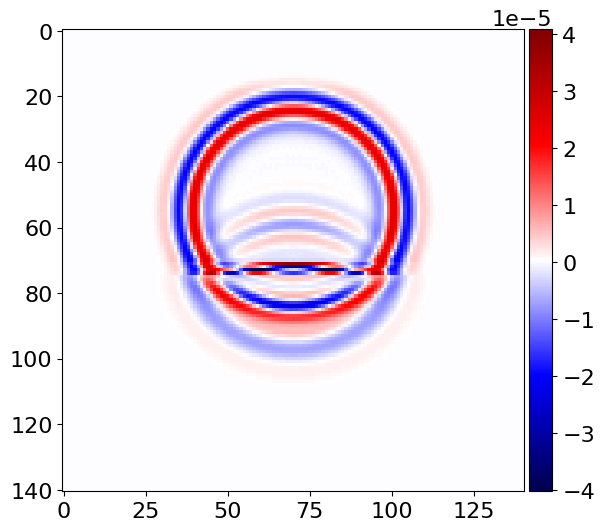

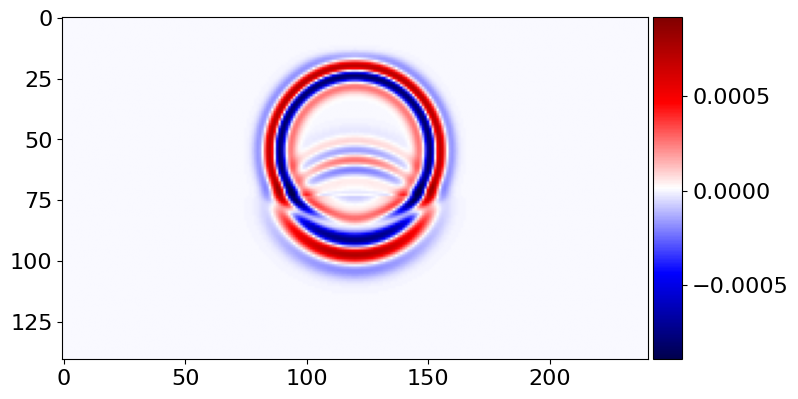

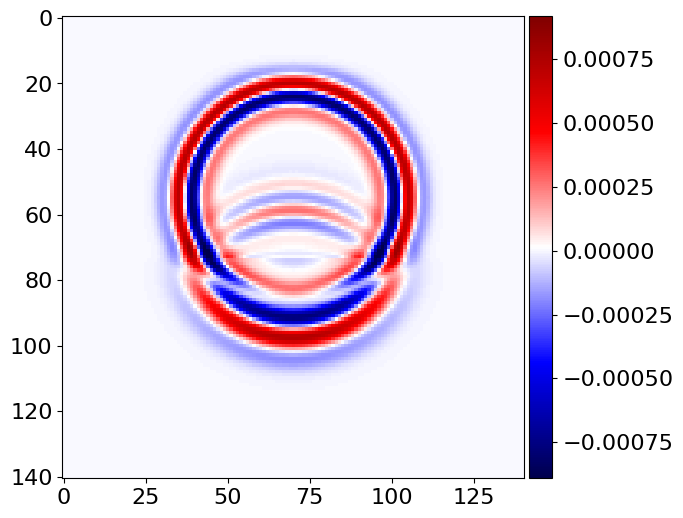

In [14]:
#NBVAL_SKIP

# Mid-points:
mid_x = int(0.5*(v[0].data.shape[1]-1))+1
mid_y = int(0.5*(v[0].data.shape[2]-1))+1

# Plot some selected results:

plot_image(v[0].data[1, :, mid_y, :], cmap="seismic")
plot_image(v[0].data[1, mid_x, :, :], cmap="seismic")

plot_image(tau[2, 2].data[1, :, mid_y, :], cmap="seismic")
plot_image(tau[2, 2].data[1, mid_x, :, :], cmap="seismic")

In [15]:
#NBVAL_IGNORE_OUTPUT

assert np.isclose(norm(v[0]), 0.102959, atol=1e-4, rtol=0)

# References

[1] Johan O. A. Roberston, *et.al.* (1994). "Viscoelastic finite-difference modeling" GEOPHYSICS, 59(9), 1444-1456.


[2] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf